# Set up

In [ ]:
pip install transformers -q

In [ ]:
from transformers import pipeline

In [ ]:
emotion = pipeline('sentiment-analysis', model='arpanghoshal/EmoRoBERTa')

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at arpanghoshal/EmoRoBERTa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [ ]:
from google.colab import auth
import gspread
from google.auth import default
#autenticating to google
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

In [ ]:
import pandas as pd
# defining my worksheet
worksheet = gc.open('output').sheet1
# get_all_values gives a list of rows
rows = worksheet.get_all_values()
# Convert to a DataFrame 
df = pd.DataFrame(rows)

In [ ]:
# creating columns name
df.columns = df.iloc[0]
df = df.iloc[1:]

# Check dataframe

In [ ]:
df.head(5)

,,dataset,category,subreddit,author,created_date,score,text,text_clean,label_1,label_2,label_3,final_label,truncated_text,emotion,pn_emotion
1,1,train,comment,r/cscareerquestions,Linooney,4/30/2020 1:58,20,> People wait for existing faculty to die to h...,people wait for existing faculty to die to hav...,POSITIVE,POSITIVE,NEUTRAL,POSITIVE,[CLS] people wait for existing faculty to die ...,neutral,NEUTRAL
2,2,train,comment,r/cscareerquestions,Dunan,4/30/2020 4:07,1,"> People who are being layed off, are they sof...",people who are being layed off are they softwa...,POSITIVE,POSITIVE,NEUTRAL,POSITIVE,[CLS] people who are being layed off are they ...,approval,POSITIVE
3,3,train,comment,r/cscareerquestions,wtfnowdoIdo,1/2/2021 0:08,0,"> Personally, I switched jobs after 1.5 years ...",personally i switched jobs after years of expe...,POSITIVE,POSITIVE,NEUTRAL,POSITIVE,[CLS] personally i switched jobs after years o...,approval,POSITIVE
4,4,train,comment,r/cscareerquestions,nyamuk91,4/28/2020 16:31,6,"> PM's don't do performance reviews, that's fo...",pms dont do performance reviews thats for mana...,NEUTRAL,POSITIVE,NEUTRAL,POSITIVE,[CLS] pms dont do performance reviews thats fo...,neutral,NEUTRAL
5,5,train,comment,r/cscareerquestions,OldSWEThrowaway,7/10/2021 2:19,-1,> pretty hard\nMore like impossible due to leg...,pretty hard more like impossible due to legal ...,POSITIVE,NEGATIVE,NEGATIVE,NEGATIVE,[CLS] pretty hard more like impossible due to ...,neutral,NEUTRAL


In [ ]:
df.shape

(18144, 16)

# Tokenize

In [ ]:
from transformers import AutoTokenizer

# load tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

max_length = 512
df['truncated_text'] = df['text_clean'].apply(lambda x: tokenizer.encode(x, max_length=max_length, truncation=True, return_tensors='pt'))
df['truncated_text'] = df['truncated_text'].apply(lambda x: tokenizer.decode(x[0][:max_length].tolist()))

# filter out rows with length > 512
df = df[df['truncated_text'].apply(len) <= 512]

# Calculate emotion

In [ ]:
def get_emotion_label(text):
  return(emotion(text)[0]['label']) # Use [0] to access the first element of the list

In [ ]:
# apply emotion function to truncated text
df['emotion'] = df['truncated_text'].apply(get_emotion_label)

In [ ]:
df.head(10)

# Map to POSITIVE / NEUTRAL / NEGATIVE

In [ ]:
emotion_labels = {
    'admiration': 'POSITIVE',
    'amusement': 'POSITIVE',
    'approval': 'POSITIVE',
    'caring': 'POSITIVE',
    'desire': 'POSITIVE',
    'excitement': 'POSITIVE',
    'gratitude': 'POSITIVE',
    'joy': 'POSITIVE',
    'love': 'POSITIVE',
    'optimism': 'POSITIVE',
    'pride': 'POSITIVE',
    'relief': 'POSITIVE',
    'anger': 'NEGATIVE',
    'annoyance': 'NEGATIVE',
    'disappointment': 'NEGATIVE',
    'disapproval': 'NEGATIVE',
    'disgust': 'NEGATIVE',
    'embarrassment': 'NEGATIVE',
    'fear': 'NEGATIVE',
    'grief': 'NEGATIVE',
    'nervousness': 'NEGATIVE',
    'remorse': 'NEGATIVE',
    'sadness': 'NEGATIVE',
    'neutral': 'NEUTRAL',
}

# Define a lambda function to map the emotion labels to positive, negative or neutral
def map_emotion(emotion):
    return emotion_labels.get(emotion, 'NEUTRAL')

# Apply the lambda function to create the new column
df['pn_emotion'] = df['emotion'].apply(map_emotion)

In [ ]:
df.head(10)

# Export the dataframe to a csv file

In [ ]:
from google.colab import files
df.to_csv('output.csv', encoding = 'utf-8-sig') 
files.download('output.csv')

# Visualise the data

Text(0.5, 1.0, 'Emotion Distribution')

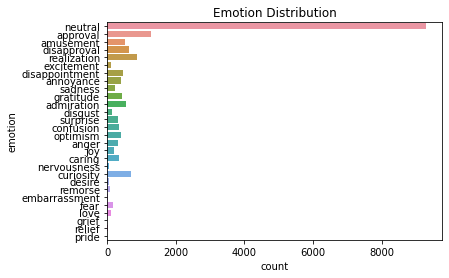

In [ ]:
import seaborn as sns
sns.countplot(data = df, y = 'emotion').set_title("Emotion Distribution")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

df['match_1'] = np.where(df['pn_emotion'] == df['label_1'], 'MATCH', 'NOMATCH')
df['match_2'] = np.where(df['pn_emotion'] == df['label_2'], 'MATCH', 'NOMATCH')
df['match_3'] = np.where(df['pn_emotion'] == df['label_3'], 'MATCH', 'NOMATCH')
df['match_final'] = np.where(df['pn_emotion'] == df['final_label'], 'MATCH', 'NOMATCH')
df['match_any'] = np.where((df['pn_emotion'] == df['label_1']) | (df['pn_emotion'] == df['label_2']) | (df['pn_emotion'] == df['label_3']), 'MATCH', 'NOMATCH')


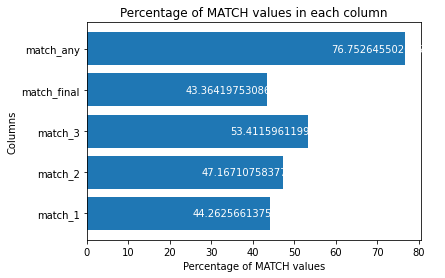

In [ ]:
match_1_pct = df['match_1'].value_counts(normalize=True)['MATCH'] * 100
match_2_pct = df['match_2'].value_counts(normalize=True)['MATCH'] * 100
match_3_pct = df['match_3'].value_counts(normalize=True)['MATCH'] * 100
match_final_pct = df['match_final'].value_counts(normalize=True)['MATCH'] * 100
match_any_pct = df['match_any'].value_counts(normalize=True)['MATCH'] * 100

fig, ax = plt.subplots()
values = [match_1_pct, match_2_pct, match_3_pct, match_final_pct, match_any_pct]
bars = ax.barh(['match_1', 'match_2', 'match_3', 'match_final', 'match_any'], values, align='center')
ax.set_xlabel('Percentage of MATCH values')
ax.set_ylabel('Columns')
ax.set_title('Percentage of MATCH values in each column')
for i, bar in enumerate(bars):
    ax.text(bar.get_width() - 5, bar.get_y() + bar.get_height() / 2, 
            str(values[i])+'%', ha='center', va='center', color='white')
plt.show()

In [ ]:
df.head(30)

,,dataset,category,subreddit,author,created_date,score,text,text_clean,label_1,...,label_3,final_label,truncated_text,emotion,pn_emotion,match_1,match_2,match_3,match_final,match_any
1,1,train,comment,r/cscareerquestions,Linooney,4/30/2020 1:58,20,> People wait for existing faculty to die to h...,people wait for existing faculty to die to hav...,POSITIVE,...,NEUTRAL,POSITIVE,[CLS] people wait for existing faculty to die ...,neutral,NEUTRAL,NOMATCH,NOMATCH,MATCH,NOMATCH,MATCH
2,2,train,comment,r/cscareerquestions,Dunan,4/30/2020 4:07,1,"> People who are being layed off, are they sof...",people who are being layed off are they softwa...,POSITIVE,...,NEUTRAL,POSITIVE,[CLS] people who are being layed off are they ...,approval,POSITIVE,MATCH,MATCH,NOMATCH,MATCH,MATCH
3,3,train,comment,r/cscareerquestions,wtfnowdoIdo,1/2/2021 0:08,0,"> Personally, I switched jobs after 1.5 years ...",personally i switched jobs after years of expe...,POSITIVE,...,NEUTRAL,POSITIVE,[CLS] personally i switched jobs after years o...,approval,POSITIVE,MATCH,MATCH,NOMATCH,MATCH,MATCH
4,4,train,comment,r/cscareerquestions,nyamuk91,4/28/2020 16:31,6,"> PM's don't do performance reviews, that's fo...",pms dont do performance reviews thats for mana...,NEUTRAL,...,NEUTRAL,POSITIVE,[CLS] pms dont do performance reviews thats fo...,neutral,NEUTRAL,MATCH,NOMATCH,MATCH,NOMATCH,MATCH
5,5,train,comment,r/cscareerquestions,OldSWEThrowaway,7/10/2021 2:19,-1,> pretty hard\nMore like impossible due to leg...,pretty hard more like impossible due to legal ...,POSITIVE,...,NEGATIVE,NEGATIVE,[CLS] pretty hard more like impossible due to ...,neutral,NEUTRAL,NOMATCH,NOMATCH,NOMATCH,NOMATCH,NOMATCH
6,7,train,comment,r/cscareerquestions,CoderDispose,1/20/2023 20:21,1,"> PTO is seen as similar to a bonus\nRight, an...",pto is seen as similar to a bonus right and on...,POSITIVE,...,NEUTRAL,POSITIVE,[CLS] pto is seen as similar to a bonus right ...,amusement,POSITIVE,MATCH,MATCH,NOMATCH,MATCH,MATCH
7,8,train,comment,r/cscareerquestions,fried_green_baloney,4/28/2020 19:22,3,> realistic timelines\nOne of the points of Ag...,realistic timelines one of the points of agile...,POSITIVE,...,NEUTRAL,POSITIVE,[CLS] realistic timelines one of the points of...,disapproval,NEGATIVE,NOMATCH,NOMATCH,NOMATCH,NOMATCH,NOMATCH
8,10,train,comment,r/cscareerquestions,seajobss,11/3/2017 3:18,1,> Safe to say I should give up on snap\nshould...,safe to say i should give up on snap shouldve ...,POSITIVE,...,NEGATIVE,POSITIVE,[CLS] safe to say i should give up on snap sho...,realization,NEUTRAL,NOMATCH,NOMATCH,NOMATCH,NOMATCH,NOMATCH
9,11,train,comment,r/cscareerquestions,troublemaker74,10/1/2022 13:09,4,"> saying ""I was laid off"" isn't going to hurt ...",saying i was laid off isnt going to hurt you l...,POSITIVE,...,NEGATIVE,POSITIVE,[CLS] saying i was laid off isnt going to hurt...,approval,POSITIVE,MATCH,MATCH,NOMATCH,MATCH,MATCH
10,12,train,comment,r/cscareerquestions,DMayr,2/6/2023 1:21,2,"> seems pretty taxing\nI have a ""default"" repl...",seems pretty taxing i have a default reply tha...,POSITIVE,...,NEUTRAL,POSITIVE,[CLS] seems pretty taxing i have a default rep...,amusement,POSITIVE,MATCH,MATCH,NOMATCH,MATCH,MATCH
